## Setup

In [1]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances

## Load Data

In [2]:
df = pd.read_csv('../../data/sample/pokemon.csv')

## Explore Data

In [3]:
df.shape

(801, 41)

In [4]:
df.head(2)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0


In [5]:
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

## Clean Data

In [6]:
def get_col(df, key_word):
    return [col for col in df.columns if col.startswith(key_word)]

In [7]:
against_feature = get_col(df, 'against_')
base_feature = get_col(df, 'base_')
sp = get_col(df, 'sp_')
important_basic = ['hp', 'attack', 'defense', 'speed']

In [8]:
select_features = sp + important_basic
select_features

['sp_attack', 'sp_defense', 'hp', 'attack', 'defense', 'speed']

In [9]:
df_input = df[select_features]

In [10]:
std_scale = StandardScaler()
df_scale = pd.DataFrame(std_scale.fit_transform(df_input), columns=df_input.columns)

## Modeling

In [11]:
def get_a_mod_list_and_dict(df, cluster_range, seed=10):
    mod_dict = {}
    for k in cluster_range:
        mod = KMeans(n_clusters=k, random_state=seed).fit(df)
        mod_dict[str(k)] = mod
    mod_list = list(mod_dict.values())
    return mod_dict, mod_list

In [12]:
def cluster_selection_plot(df, mod_list, cluster_range):
    within_ss = [i.inertia_ for i in mod_list]
    silhouette_list = [silhouette_score(df, i.labels_) for i in mod_list]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axs[0].plot(cluster_range, within_ss, color='royalblue')
    axs[1].plot(cluster_range, silhouette_list, color='green')
    
    for i in range(2): 
        axs[i].set_xlabel('number of clusters')
    for idx, name in zip([0,1,2], ['inertia', 'silhouette score']): 
        axs[idx].set_ylabel(name)
    
    plt.show()

In [13]:
cluster_range = range(3, 12)

In [14]:
mod_dict, mod_list = get_a_mod_list_and_dict(df_scale, cluster_range)

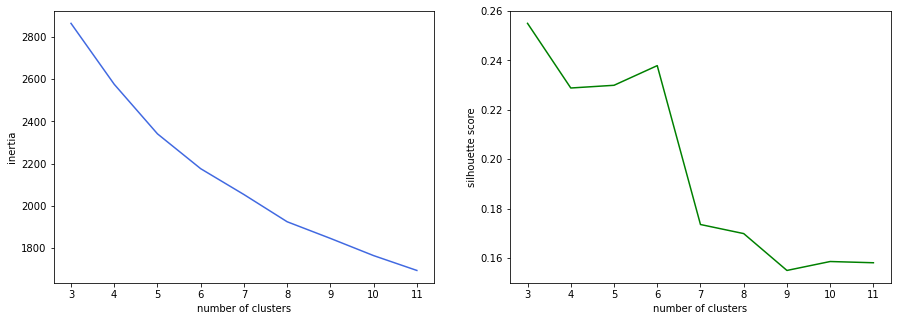

In [15]:
cluster_selection_plot(df_scale, mod_list, cluster_range)

<div class="alert alert-info">We choose k = 6 because it produces a silhouette score that is better than the surrounding choices of $k$ and $k$ equals to 3 is too small for our use case. </div>

In [16]:
k_final = 6

In [17]:
final_mod = mod_dict[str(k_final)]

## Explore Cluster

In [18]:
def summary_kmeans(df, mod):
    df_summary = pd.DataFrame(mod.cluster_centers_, columns=list(df.columns))
    df_summary['count'] = pd.Series(mod.labels_).value_counts().sort_index()
    df_summary['percent'] = df_summary['count']/df_summary['count'].sum()
    columns_ordered = ['count', 'percent'] + list(df.columns)
    df_summary = df_summary[columns_ordered]
    return df_summary

In [19]:
def summary_plot(df, mod):
    df_summary = summary_kmeans(df, mod)
    x_max = df_summary.iloc[:,2:].values.max()
    x_min = df_summary.iloc[:,2:].values.min()
    
    fig, axs = plt.subplots(nrows=1, ncols=mod.n_clusters, figsize=(25,5))
    for i in range(mod.n_clusters):
        if i > 0:
            axs[i].get_yaxis().set_ticklabels([])
        axs[i].scatter(x=df_summary.iloc[i, 2:].values, y=list(df.columns), color='royalblue')
        axs[i].set_xlabel(f'cluster{str(i)}')
        axs[i].set_xlim(x_min-0.5, x_max+0.5)
    plt.show()

In [20]:
def lift_plot(df_scale, mod, feature_names):
    df = df_scale.copy(deep=True)
    df['cluster_label'] = mod.predict(df)
    cluster_means = df.groupby('cluster_label')[feature_names].mean()
    population_means = df[feature_names].mean()
    lifts = cluster_means.divide(population_means)
    
    fig, ax = plt.subplots(figsize=(16, 10))

    xticklabels = lifts.index.tolist() 
    yticklabels = lifts.columns.tolist()

    ax = sns.heatmap(lifts.T, center=1, vmax=2.5, cmap=sns.diverging_palette(10, 220, sep=80, n=7),
                    xticklabels=xticklabels, yticklabels=yticklabels)
    ax.set_xlabel('Cluster number')
    ax.set_title('Lift in cluster features (Cluster mean/population mean)')
    plt.show()

In [21]:
df_sum = summary_kmeans(df_scale, final_mod)

In [22]:
df_sum

,count,percent,sp_attack,sp_defense,hp,attack,defense,speed
0,289,0.360799,-0.740377,-0.824052,-0.727766,-0.752670,-0.733624,-0.582302
1,120,0.149813,-0.325694,-0.003093,0.321275,0.973404,0.991316,-0.284459
2,42,0.052434,0.191569,0.358718,2.314424,-0.097807,-0.185341,-0.490416
3,91,0.113608,0.491159,1.325395,-0.017895,-0.358353,0.905641,-0.508357
4,157,0.196005,0.262585,-0.006406,-0.014756,0.107485,-0.292553,1.027957
5,102,0.127341,1.559659,1.018146,0.769714,1.181921,0.630994,1.057736


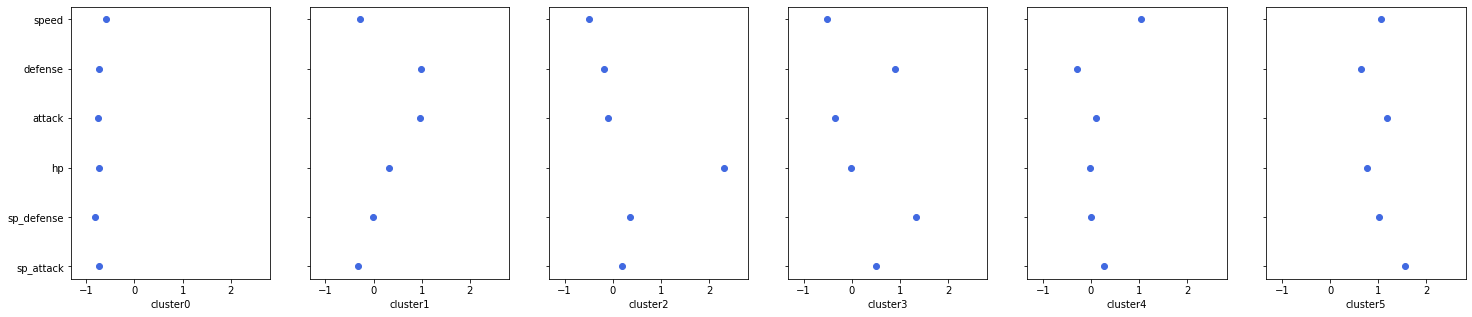

In [23]:
summary_plot(df_scale, final_mod)

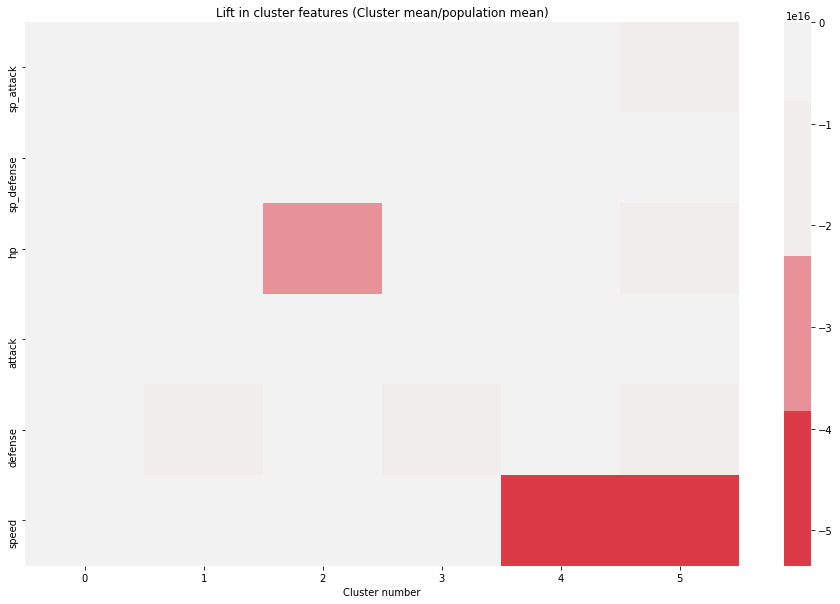

In [24]:
lift_plot(df_scale, final_mod, select_features)

## Generate Recommendation

In [25]:
df_prepared = df_scale.copy(deep=True)

In [26]:
df_prepared = df_prepared.assign(cluster_label = final_mod.predict(df_scale),
                                 name = df['name'])

In [27]:
df_prepared.head(5)

,sp_attack,sp_defense,hp,attack,defense,speed,cluster_label,name
0,-0.195025,-0.211687,-0.902083,-0.897909,-0.780773,-0.738486,0,Bulbasaur
1,0.268888,0.325465,-0.337312,-0.493413,-0.325488,-0.219268,4,Ivysaur
2,1.567846,1.757871,0.415717,0.688960,1.625735,0.473022,5,Venusaur
3,-0.349663,-0.748839,-1.127992,-0.804564,-0.975896,-0.046196,0,Charmander
4,0.268888,-0.211687,-0.412614,-0.431183,-0.488090,0.473022,4,Charmeleon


In [28]:
def filter_by_cluster(df, cluster_idx):
    return df.query('cluster_label == @cluster_idx').reset_index(drop=True)

In [29]:
def closest_k_in_cluster(df_one_cluster: pd.DataFrame, features: List, k: int = 10):
    dist_mtx = pairwise_distances(df_one_cluster[select_features])
    return np.argsort(dist_mtx)[:, :11]

In [30]:
def get_mapping_to_df(df_one_cluster: pd.DataFrame, closest_info: np.ndarray) -> pd.DataFrame:
    int2str = df_one_cluster['name'].to_dict()
    
    # Adapted from: https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    map_cloest_info = np.vectorize(int2str.get)(closest_info)
    
    df_info = pd.DataFrame(map_cloest_info, columns=['input'] + [f'rec{i}' for i in range(1, 11)])
    return df_info

In [31]:
result = []
for i in range(0, k_final):
    df_one_clus = filter_by_cluster(df_prepared, i)
    cloest_info = closest_k_in_cluster(df_one_clus, select_features)
    df_info = get_mapping_to_df(df_one_clus, cloest_info)
    result.append(df_info)
df_result = pd.concat(result, axis=0)

In [32]:
df_result.head(3)

,input,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10
0,Bulbasaur,Vanillite,Popplio,Piplup,Clauncher,Oddish,Lombre,Gothita,Fennekin,Psyduck,Goomy
1,Charmander,Cyndaquil,Froakie,Chimchar,Natu,Treecko,Electrike,Fennekin,Delibird,Panpour,Pansear
2,Squirtle,Chikorita,Clauncher,Sewaddle,Binacle,Mareanie,Klink,Swablu,Piplup,Bulbasaur,Baltoy


In [33]:
df_long = df_result.melt(id_vars=['input'], var_name='the_rank', value_name='recommendation')
df_long['the_rank'] = df_long.the_rank.str.replace('rec', '').astype(int)
df_long = df_long.sort_values(['input', 'the_rank'], ignore_index=True)

In [34]:
df_long.head(20)

,input,the_rank,recommendation
0,Abomasnow,1,Exeggutor
1,Abomasnow,2,Ampharos
2,Abomasnow,3,Celesteela
3,Abomasnow,4,Volcanion
4,Abomasnow,5,Magearna
5,Abomasnow,6,Swampert
6,Abomasnow,7,Necrozma
7,Abomasnow,8,Dragonite
8,Abomasnow,9,Blastoise
9,Abomasnow,10,Altaria


## Get Recommendation

In [35]:
def get_url(name): 
    return f'https://pokemondb.net/pokedex/{name}'